## Calculate the chance of being born in Canada as a function of the year

### First, I'll pull the data from the Worldbank API
### Then I'll store the data in a sqlite database
### Next, I'll query the database to get the data I need into a pandas dataframe

### To calculate the chance of being born in Canada as a function of the year, I will calculate the raw births per year for Canada and the world.

### -      births per year = (birth rate / 1000) * population / 1000

### Then I'll divide the number of births in Canada by the number of births in the world to get the chance of being born in Canada as a function of the year.


In [18]:
import matplotlib.pylab as plt
import pandas as pd
import sqlite3
import requests
import time
from datetime import datetime
import pycountry

In [2]:
birth_rate_source = 'https://api.worldbank.org/v2/country/all/indicator/SP.DYN.CBRT.IN'
population_source = 'https://api.worldbank.org/v2/country/all/indicator/SP.POP.TOTL'

# "CA" Canada country code

params = {
    'format': 'json',
    'per_page': 1000,  # Maximum records per page
    'page': 1,
    'date': '1973:2023',
}
db_path = "public_data.db"

In [3]:
"""Create SQLite database and tables"""
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Create a general table for World Bank indicators
cursor.execute("""
    CREATE TABLE IF NOT EXISTS world_bank_data (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        country_code TEXT,
        country_name TEXT,
        indicator_code TEXT,
        indicator_name TEXT,
        year INTEGER,
        value REAL,
        decimal_places INTEGER,
        obs_status TEXT,
        unit TEXT,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
    )
""")

# Create an index for faster queries
cursor.execute("""
    CREATE INDEX IF NOT EXISTS idx_country_indicator_year 
    ON world_bank_data(country_code, indicator_code, year)
""")

conn.commit()
conn.close()
print(f"Database created: {db_path}")

Database created: public_data.db


In [4]:
def pull_wb_data(source_url):
    """Pull data from the source worldbank URL."""
    all_data = []
    session = requests.Session()
    session.headers.update({
        'User-Agent': 'Mozilla/5.0 (compatible; DataFetcher/1.0)'
    })

    while True:
        response = session.get(source_url, params=params, timeout=30)
        response.raise_for_status()

        data = response.json()
        
        # World Bank API returns metadata in first element, data in second
        if len(data) < 2 or not data[1]:
            break
        
        metadata = data[0]
        records = data[1]
        
        all_data.extend(records)
        
        # Check if there are more pages
        if params['page'] >= metadata.get('pages', 1):
            break
        
        params['page'] += 1
        time.sleep(0.5)

    print(f"Successfully fetched {len(all_data)} records")
    params['page'] = 1  # Reset page index

    return all_data

In [5]:
birth_rate_data = pull_wb_data('https://api.worldbank.org/v2/country/all/indicator/SP.DYN.CBRT.IN')
population_data = pull_wb_data('https://api.worldbank.org/v2/country/all/indicator/SP.POP.TOTL')

Successfully fetched 13566 records
Successfully fetched 13566 records


In [6]:
def store_data(data, indicator):
    """Save World Bank data to SQLite database"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    cursor.execute("DELETE FROM world_bank_data WHERE indicator_code = ?", (indicator,))

    # Prepare data for insertion
    records = []
    for item in data:
        if item is None:
            continue
            
        record = (
            item.get('country', {}).get('id', ''),
            item.get('country', {}).get('value', ''),
            item.get('indicator', {}).get('id', ''),
            item.get('indicator', {}).get('value', ''),
            item.get('date'),
            item.get('value'),
            item.get('decimal'),
            item.get('obs_status'),
            item.get('unit'),
        )
        records.append(record)

    # Insert data
    cursor.executemany("""
        INSERT INTO world_bank_data 
        (country_code, country_name, indicator_code, indicator_name, year, value, 
            decimal_places, obs_status, unit) 
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, records)

    conn.commit()
    conn.close()
    print(f"Saved {len(records)} records to database")

In [7]:
store_data(birth_rate_data, "birthrate")
store_data(population_data, "population")

Saved 13566 records to database
Saved 13566 records to database


In [3]:
def query_data(query: str):
    """Execute a query on the database"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    cursor.execute(query)
    results = cursor.fetchall()
    results = pd.DataFrame(results)
    
    conn.close()
    return results

In [4]:
# SP.POP.TOTL = population
# SP.DYN.CBRT.IN = birthrate

In [5]:
query = """
        SELECT year, country_code, value
        FROM world_bank_data
        WHERE indicator_code='SP.DYN.CBRT.IN'
    """
birth_rate_data = query_data(query=query)
print(birth_rate_data)  # Quick test

          0   1          2
0      2023  ZH  32.954912
1      2022  ZH  33.320433
2      2021  ZH  33.681336
3      2020  ZH  34.010470
4      2019  ZH  34.335881
...     ...  ..        ...
13561  1977  ZW  46.510000
13562  1976  ZW  46.524000
13563  1975  ZW  46.623000
13564  1974  ZW  46.395000
13565  1973  ZW  46.384000

[13566 rows x 3 columns]


In [44]:
query = """
        SELECT year, country_code, value
        FROM world_bank_data
        WHERE indicator_code='SP.POP.TOTL'
    """
population_data = query_data(query=query)
print(population_data)  # Quick test

# I found there were quite a few "aggregates" at this point (e.g. North America)

          0   1            2
0      2023  ZH  750503764.0
1      2022  ZH  731821393.0
2      2021  ZH  713090928.0
3      2020  ZH  694446100.0
4      2019  ZH  675950189.0
...     ...  ..          ...
13561  1977  ZW    6449512.0
13562  1976  ZW    6287105.0
13563  1975  ZW    6098658.0
13564  1974  ZW    5908328.0
13565  1973  ZW    5720404.0

[13566 rows x 3 columns]


In [22]:
# Get a list of all countries
all_countries = list(pycountry.countries)
country_codes = []

# Print the alpha-2 code and name for each country
for country in all_countries:
    country_codes.append(country.alpha_2)

country_codes

['AW',
 'AF',
 'AO',
 'AI',
 'AX',
 'AL',
 'AD',
 'AE',
 'AR',
 'AM',
 'AS',
 'AQ',
 'TF',
 'AG',
 'AU',
 'AT',
 'AZ',
 'BI',
 'BE',
 'BJ',
 'BQ',
 'BF',
 'BD',
 'BG',
 'BH',
 'BS',
 'BA',
 'BL',
 'BY',
 'BZ',
 'BM',
 'BO',
 'BR',
 'BB',
 'BN',
 'BT',
 'BV',
 'BW',
 'CF',
 'CA',
 'CC',
 'CH',
 'CL',
 'CN',
 'CI',
 'CM',
 'CD',
 'CG',
 'CK',
 'CO',
 'KM',
 'CV',
 'CR',
 'CU',
 'CW',
 'CX',
 'KY',
 'CY',
 'CZ',
 'DE',
 'DJ',
 'DM',
 'DK',
 'DO',
 'DZ',
 'EC',
 'EG',
 'ER',
 'EH',
 'ES',
 'EE',
 'ET',
 'FI',
 'FJ',
 'FK',
 'FR',
 'FO',
 'FM',
 'GA',
 'GB',
 'GE',
 'GG',
 'GH',
 'GI',
 'GN',
 'GP',
 'GM',
 'GW',
 'GQ',
 'GR',
 'GD',
 'GL',
 'GT',
 'GF',
 'GU',
 'GY',
 'HK',
 'HM',
 'HN',
 'HR',
 'HT',
 'HU',
 'ID',
 'IM',
 'IN',
 'IO',
 'IE',
 'IR',
 'IQ',
 'IS',
 'IL',
 'IT',
 'JM',
 'JE',
 'JO',
 'JP',
 'KZ',
 'KE',
 'KG',
 'KH',
 'KI',
 'KN',
 'KR',
 'KW',
 'LA',
 'LB',
 'LR',
 'LY',
 'LC',
 'LI',
 'LK',
 'LS',
 'LT',
 'LU',
 'LV',
 'MO',
 'MF',
 'MA',
 'MC',
 'MD',
 'MG',
 'MV',
 'MX',

### Filter only ISO 3166-1 alpha-2 codes for countries

In [ ]:
# Join the two datasets
combined_dataframe = pd.merge(left=population_data, right=birth_rate_data, how='left', left_on=[0, 1], right_on=[0, 1])
combined_dataframe = combined_dataframe.rename(columns={0: "Year", 1:"Country Code", "2_x": "Population", "2_y": "Birth rate / 1000",})
combined_dataframe = combined_dataframe[combined_dataframe['Country Code'].isin(country_codes)]
combined_dataframe

,Year,Country Code,Population,Birth rate / 1000
2499,2023,AF,41454761.0,35.437
2500,2022,AF,40578842.0,36.045
2501,2021,AF,40000412.0,36.342
2502,2020,AF,39068979.0,36.601
2503,2019,AF,37856121.0,37.138
...,...,...,...,...
13561,1977,ZW,6449512.0,46.510
13562,1976,ZW,6287105.0,46.524
13563,1975,ZW,6098658.0,46.623
13564,1974,ZW,5908328.0,46.395


In [25]:
combined_dataframe["Births"] = combined_dataframe["Population"] * combined_dataframe["Birth rate / 1000"] / 1000
combined_dataframe

,Year,Country Code,Population,Birth rate / 1000,Births
2499,2023,AF,41454761.0,35.437,1.469032e+06
2500,2022,AF,40578842.0,36.045,1.462664e+06
2501,2021,AF,40000412.0,36.342,1.453695e+06
2502,2020,AF,39068979.0,36.601,1.429964e+06
2503,2019,AF,37856121.0,37.138,1.405901e+06
...,...,...,...,...,...
13561,1977,ZW,6449512.0,46.510,2.999668e+05
13562,1976,ZW,6287105.0,46.524,2.925013e+05
13563,1975,ZW,6098658.0,46.623,2.843377e+05
13564,1974,ZW,5908328.0,46.395,2.741169e+05


In [ ]:
# Calculated the number of births in the World.
total_births = combined_dataframe.groupby(combined_dataframe["Year"])["Births"].sum()
total_births

Year
1973    1.198227e+08
1974    1.187668e+08
1975    1.182982e+08
1976    1.170954e+08
1977    1.175851e+08
1978    1.185408e+08
1979    1.203187e+08
1980    1.228177e+08
1981    1.271278e+08
1982    1.304795e+08
1983    1.301708e+08
1984    1.313198e+08
1985    1.336579e+08
1986    1.364955e+08
1987    1.384272e+08
1988    1.385319e+08
1989    1.385108e+08
1990    1.387568e+08
1991    1.377728e+08
1992    1.363208e+08
1993    1.363230e+08
1994    1.363315e+08
1995    1.360785e+08
1996    1.363010e+08
1997    1.363144e+08
1998    1.357976e+08
1999    1.352253e+08
2000    1.357104e+08
2001    1.355385e+08
2002    1.352408e+08
2003    1.352508e+08
2004    1.358143e+08
2005    1.364647e+08
2006    1.372227e+08
2007    1.384774e+08
2008    1.399378e+08
2009    1.406040e+08
2010    1.411420e+08
2011    1.436456e+08
2012    1.462541e+08
2013    1.441191e+08
2014    1.451665e+08
2015    1.430358e+08
2016    1.450197e+08
2017    1.426041e+08
2018    1.398353e+08
2019    1.382767e+08
2020    

In [ ]:
# Then calculate the number of births in Canada over time.
canada_stats = combined_dataframe.loc[combined_dataframe['Country Code'] == "CA"]
canada_births = canada_stats.groupby(canada_stats["Year"])["Births"].sum()
canada_births

Year
1973    350871.7212
1974    351242.7226
1975    365663.7450
1976    365817.0048
1977    367750.5665
1978    364240.6856
1979    372703.7776
1980    377541.2718
1981    379744.6995
1982    379265.8242
1983    380496.7650
1984    384105.7950
1985    385047.5284
1986    378454.0310
1987    380831.0544
1988    388480.3315
1989    406424.0369
1990    415367.0700
1991    403738.8480
1992    400034.8224
1993    390112.7904
1994    385708.8179
1995    377999.8119
1996    367166.7032
1997    349899.5916
1998    343768.9722
1999    337454.2746
2000    328337.3110
2001    335025.2340
2002    329271.5895
2003    335410.0866
2004    338551.3542
2005    344997.2324
2006    358283.1230
2007    371644.4118
2008    382343.9270
2009    383382.7866
2010    380866.1024
2011    377731.4310
2012    381847.3450
2013    382382.8128
2014    386231.3194
2015    382038.1286
2016    382774.5118
2017    376414.2725
2018    374433.4620
2019    372423.1005
2020    361272.0610
2021    370926.6808
2022    350423.

In [ ]:
# Finally divide Canadian births by the total worlds.
odds_canadian = canada_births / total_births
odds_canadian

Year
1973    0.002928
1974    0.002957
1975    0.003091
1976    0.003124
1977    0.003128
1978    0.003073
1979    0.003098
1980    0.003074
1981    0.002987
1982    0.002907
1983    0.002923
1984    0.002925
1985    0.002881
1986    0.002773
1987    0.002751
1988    0.002804
1989    0.002934
1990    0.002993
1991    0.002930
1992    0.002935
1993    0.002862
1994    0.002829
1995    0.002778
1996    0.002694
1997    0.002567
1998    0.002531
1999    0.002495
2000    0.002419
2001    0.002472
2002    0.002435
2003    0.002480
2004    0.002493
2005    0.002528
2006    0.002611
2007    0.002684
2008    0.002732
2009    0.002727
2010    0.002698
2011    0.002630
2012    0.002611
2013    0.002653
2014    0.002661
2015    0.002671
2016    0.002639
2017    0.002640
2018    0.002678
2019    0.002693
2020    0.002686
2021    0.002784
2022    0.002652
2023    0.002681
Name: Births, dtype: float64

### The odds of being born in Canada in 2023 is approximately 0.0026 or 0.26% based on my calculations.

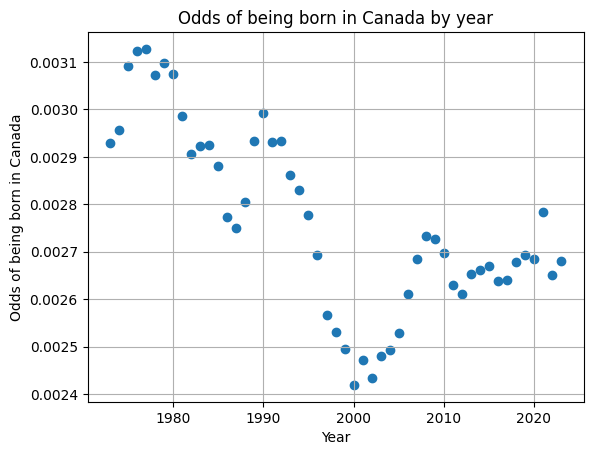

In [39]:


fig, ax = plt.subplots()
ax.grid()
plt.scatter(odds_canadian.index, odds_canadian)

ax.set(xlabel='Year', ylabel='Odds of being born in Canada',
       title='Odds of being born in Canada by year')


plt.show()

### One interesting observation is that the odds of being born in Canada decreased from ~1977 to 2000 dramatically, but slightly increased after this. I looked at World vs Canada births after this.

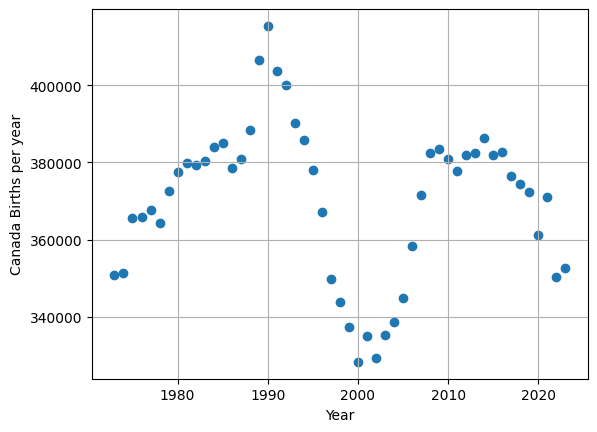

In [ ]:
fig, ax = plt.subplots()
ax.grid()
plt.scatter(canada_births.index, canada_births)

ax.set(xlabel='Year', ylabel='Canada Births per year')

plt.show()

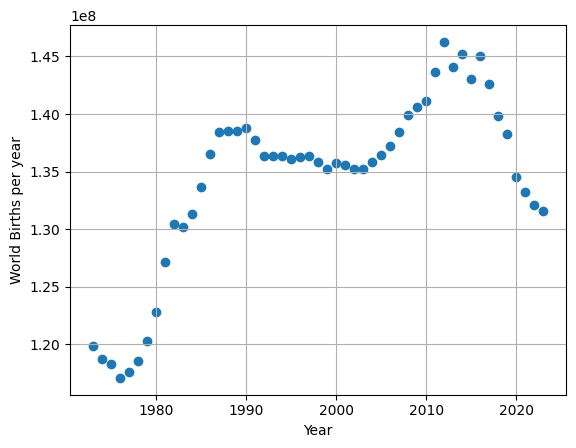

In [ ]:
fig, ax = plt.subplots()
ax.grid()
plt.scatter(total_births.index, total_births)

ax.set(xlabel='Year', ylabel='World Births per year')

plt.show()

### I found a dramatic increase in world births in the 1980s which Canada didn't quite match. World births stagnated but Canada then had a large decrease over the 90s. Likely due to the baby boomers having children in the 80s and then having less children as the 90s progressed.